# Introduction
* This program that classifies legal issues into a binary value for each National Subject Matter Index (NSMI). (https://nsmi.lsntap.org/browse-v2) \\
"Category" means 20 indexes. \\
"Class" means sub categories under the category.

### Data
* The data contains 2777 labeled articles. Each article has a binary value(0 or 1) that indicates if this article is related to a specific legal class. We ignore unlabeled entries when constructing a model.

### Implementation
* The program converts an article into tf-idf and applies multinomial Naive-Bayes model provided by scikit-learn. 

* After preprocessing data, we predict the model with 10-fold cross-validation.

### Output
* We calculate accuracy with bot categories(20) and classes(100+). \\

See overall result is at the bottom of this notebook.

# Data Preparation (DONE)

In [1]:
SOLVER = 'liblinear' 
PENALTY = "l2"


!pip3 install PrettyTable
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tqdm
!pip3 install nltk
!python3 -m nltk.downloader stopwords punkt
!python3 -m pip install prettytable

import os
import sys
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict

import sklearn.exceptions
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None) 

import collections
import matplotlib.pyplot as plt
import pylab as pl


from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import punkt
stop_words = stopwords.words('english')

from tqdm.notebook import tqdm
import collections
from prettytable import PrettyTable


print("DONE")

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /Users/heeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/heeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


DONE


In [2]:
url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


,_id,full_text,BE-00-00-00-00,BE-01-00-00-00
0,5b60e59cda52255c20cff794,Will he serve time?. Long story short my broth...,0.0,0.0
1,5b60e59cda52255c20cff79a,Groundwater leaking out of street 24/7. Ground...,0.0,0.0
2,5b60e59cda52255c20cff7a0,How do I get my mom's license taken away. My m...,0.0,0.0
3,5b60e59cda52255c20cff7bf,My boss hasn't paid me. What do i do?. I work ...,NaN,NaN
4,5b60e59cda52255c20cff7b8,"[Texas] I signed a non-compete contract, but t...",0.0,0.0
...,...,...,...,...
2772,5b60e66dda52255c20df433f,Do you and your parents get deported because o...,0.0,0.0
2773,5b60e66dda52255c20df43ae,Wondering the legality of a minor (me) being a...,0.0,0.0
2774,5b60e66dda52255c20df4462,Can I sue a billion dollar company in small cl...,0.0,0.0
2775,5b60e66dda52255c20df4448,Sued by creditor and currently in settlement n...,0.0,0.0


## Null and Rowsum Check

In [3]:

#Null Check
#df.isnull().sum()

# Class Check - Remove every column that has zero sum. 
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)


#df.info()


# Remove columns that have <10 positive classes

In [4]:
oldCols = list(df.columns)
print(len(oldCols))

newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)
        
print(len(newCols))

cols = oldCols[:2] + newCols

print(cols)
print(len(cols))

df = df[cols]

df.sum(axis=0, skipna=True)

88
36
['_id', 'full_text', 'BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']
38


_id               5b60e59cda52255c20cff7945b60e59cda52255c20cff7...
full_text         Will he serve time?. Long story short my broth...
BE-00-00-00-00                                                   27
BU-00-00-00-00                                                   93
CO-00-00-00-00                                                  106
CR-00-00-00-00                                                  302
CR-01-00-00-00                                                   12
CR-04-00-00-00                                                   13
CR-06-00-00-00                                                   11
CR-10-00-00-00                                                   11
ED-00-00-00-00                                                   24
ES-00-00-00-00                                                   78
ES-01-00-00-00                                                   10
ES-03-00-00-00                                                   13
FA-00-00-00-00                                  

# Tiny Example: Crime and Prison(CR-00-00-00-00)


## Preprocessing (DONE)

In [5]:

verbose = True
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))



## Data Preparation

In [6]:
cls = 'CR-00-00-00-00'
dfset = defaultdict() 
preprocessing(dfset, cls)    

#    model[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
tinydf = dfset[cls]
X = tinydf['full_text'].values
Y = tinydf[cls].values

------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1377
NaN    1098
1.0     302
Nam

# GloVE

## Download and Load GloVe

In [7]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


## GloVe Train & Predict

In [8]:
cls = 'CR-00-00-00-00'



# Train and Test Split
p = len(X) // 10 * 9
train_text = X[:p]
test_text = X[p:]


print("Checkpoint1 - Data Read Complete")


hit = 0
all_words = 0
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    global hit, all_words
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    hit += len(M)
    all_words += len(words)
    
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_text)]

print('Mean Train Word Hit Rate(\%)', hit / all_words * 100)
hit = 0
all_words = 0

xtest_glove = [sent2vec(x) for x in tqdm(test_text)]
print('Mean Test Word Hit Rate(\%)', hit / all_words * 100)

print('Checkpoint2 -Normalized Vector for Sentences are created')

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced')

train_target = Y[:p]
test_target = Y[p:]

model.fit(xtrain_glove, train_target)
preds = model.predict(xtest_glove)

print(preds)
accuracy = accuracy_score(test_target, preds)
precision, recall, fscore, support = score(test_target, preds)
print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Checkpoint1 - Data Read Complete



Mean Train Word Hit Rate(\%) 99.58181372991224



Mean Test Word Hit Rate(\%) 99.61077662227088
Checkpoint2 -Normalized Vector for Sentences are created
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
accuracy: 0.9147727272727273
precision: [0.99285714 0.61111111]
recall: [0.90849673 0.95652174]
fscore: [0.94880546 0.74576271]
support: [153  23]


## GloVE + Logistic Regression on CR-00-00-00-00

In [9]:

verbose = False
    
numdoc = defaultdict()

classifier = defaultdict()

    
def predict_by_class_glove(dfset: defaultdict,cls: str) -> float:
    global PENALTY, SOLVER
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)
    
    
    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    # 10-fold separation with train and test 
    #kfold = KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    print('data set size', len(X_glove))
    numdoc[cls] = len(X_glove)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)
    probs = [0] * len(Y)
    
    print('Checkpoint2 -Normalized Vector for Sentences are created')
    


    for train_index, test_index in kfold.split(X_glove, Y):

        X_train, X_test = X_glove[train_index], X_glove[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Scikit-Learn
        classifier[cls] = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000)
        classifier[cls].fit(X_train, Y_train)
        out = classifier[cls].predict(X_test)
        prob = classifier[cls].predict_proba(X_test)[:,1]
        
        

        #print(len(out))
        i = 0
        for x in test_index:
            preds[x] = out[i]
            probs[x] = prob[i]
            i += 1
            
        #print(preds)

        n_iter += 1
        
    custom_logloss = np.round(log_loss(Y, probs), 4)
    custom_brierloss = np.round(brier_score_loss(Y, probs), 4)
    print('logloss:', custom_logloss)
    print('brierloss: ',custom_brierloss)
    
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall:   tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)
    
    
    return (accuracy, precision[1], recall[1], fscore[1], support[1], custom_logloss, custom_brierloss)



#cls = 'BE-00-00-00-00'
cls = 'CR-00-00-00-00'
predict_by_class_glove(dfset, cls)


------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
Checkpoint2 -Normalized Vector for Sentences are created
logloss: 0.3583
brierloss:  0.1045


(0.8928, 0.6525, 0.8642, 0.7436, 302, 0.3583, 0.1045)

## GloVe GridSearch

In [13]:
verbose = False
numdoc = defaultdict()
classifier = defaultdict()

    
def predict_by_class_glove_grid(dfset: defaultdict,cls: str) -> float:
    global PENALTY, SOLVER
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)

    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))
    kfold = KFold(n_splits=10)
    print('data set size', len(X_glove))
    numdoc[cls] = len(X_glove)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)
    probs = [0] * len(Y)

    best_recall = 0
    best_accuracy = 0
    best_precision = 0
    best_fscore = 0
    best_support = 0
    best_model = 0
    best_c = 0
    
    best_logloss = 1
    best_brierloss = 1
    
    model = None


    for reg in range(-12, 1):
        
        c = 1.0/2.0**reg

        model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000, C = c)
        
        for train_index, test_index in kfold.split(X_glove, Y):
            X_train, X_test = X_glove[train_index], X_glove[test_index] 
            Y_train, Y_test = Y[train_index], Y[test_index]
            model.fit(X_train, Y_train)
            out = model.predict(X_test)
            prob = model.predict_proba(X_test)[:,1]

            i = 0
            for x in test_index:
                preds[x] = out[i]
                probs[x] = prob[i]
                i += 1
            n_iter += 1

            
        custom_logloss = np.round(log_loss(Y, probs), 4)
        custom_brierloss = np.round(brier_score_loss(Y, probs), 4)  
        
        c_list.append(reg)
        loss_list.append(custom_logloss)
        print('C:', c, end=' ')
        print(custom_logloss)

        accuracy = accuracy_score(Y, preds)
        precision, recall, fscore, support = score(Y, preds)
        # accuracy: (tp + tn) / (p + n)
        # precision tp / (tp + fp)
        # recall:   tp / (tp + fn)
        # f1: 2 tp / (2 tp + fp + fn)
        accuracy = np.round(accuracy, 4)
        precision[1] = np.round(precision[1], 4)
        recall[1] = np.round(recall[1], 4)
        fscore[1] = np.round(fscore[1], 4)
        support[1] = np.round(support[1], 4)

#        if best_recall < recall[1]:
        if best_logloss > custom_logloss:
            best_logloss = custom_logloss
            best_accuracy = accuracy
            best_recall = recall[1]
            best_precision = precision[1]
            best_fscore = fscore[1]
            best_support = support[1]
            best_model = model
            best_c = c
        if best_brierloss > custom_brierloss:
            best_brierloss = custom_brierloss
            
    classifier[cls] = best_model
    return (best_accuracy, best_precision, best_recall, best_fscore, best_support, best_logloss, best_brierloss, best_c, numdoc[cls])




------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
C: 4096.0 0.64
C: 2048.0 0.4949
C: 1024.0 0.3927
C: 512.0 0.3253
C: 256.0 0.2822
C: 128.0 0.2562
C: 64.0 0.243
C: 32.0 0.2397
C: 16.0 0.2455
C: 8.0 0.26
C: 4.0 0.2835
C: 2.0 0.3163
C: 1.0 0.3583
(0.9148, 0.7131, 0.8808, 0.7881, 302, 0.2397, 0.0685, 32.0, 1679)


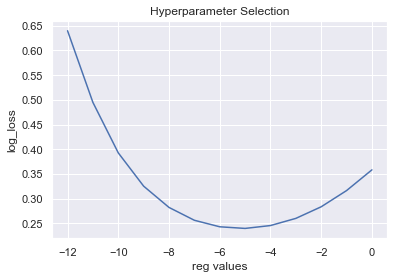

32.0


In [15]:
c_list = []
loss_list = []

cls = 'CR-00-00-00-00'
print(predict_by_class_glove_grid(dfset, cls))



# plotting the points  
plt.plot(range(-12,1), loss_list)  
plt.xlabel('reg values') 
plt.ylabel('log_loss') 
plt.title('Hyperparameter Selection') 
plt.show() 
print(classifier[cls].C)

# Entire Data 

## Build Models and Calculating Accuracies

In [16]:


class_list = df.columns[2:]
print(class_list)
verbose = False
stat_dict = defaultdict() 
for cls in tqdm(class_list):
    ret = predict_by_class_glove_grid(dfset, cls)
    stat_dict[cls] = ret 
    print('statistics' , ret)

Index(['BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00',
       'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00',
       'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00',
       'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00',
       'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00',
       'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00',
       'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00',
       'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00',
       'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00'],
      dtype='object')



------------------------------------

0.0    1821
1.0      27
Name: BE-00-00-00-00, dtype: int64
data set size 1848
C: 4096.0 0.0867
C: 2048.0 0.0805
C: 1024.0 0.0756
C: 512.0 0.0726
C: 256.0 0.0725
C: 128.0 0.0768
C: 64.0 0.0867
C: 32.0 0.1027
C: 16.0 0.1258
C: 8.0 0.1567
C: 4.0 0.1963
C: 2.0 0.245
C: 1.0 0.3027
statistics (0.9735, 0.2885, 0.5556, 0.3797, 27, 0.0725, 0.0178, 256.0, 1848)



------------------------------------

0.0    1497
1.0      93
Name: BU-00-00-00-00, dtype: int64
data set size 1590
C: 4096.0 0.1736
C: 2048.0 0.1522
C: 1024.0 0.1328
C: 512.0 0.1163
C: 256.0 0.1049
C: 128.0 0.1005
C: 64.0 0.1029
C: 32.0 0.1112
C: 16.0 0.1251
C: 8.0 0.1444
C: 4.0 0.1696
C: 2.0 0.2019
C: 1.0 0.2436
statistics (0.9635, 0.64, 0.8602, 0.7339, 93, 0.1005, 0.0283, 128.0, 1590)



------------------------------------

0.0    1058
1.0     106
Name: CO-00-00-00-00, dtype: int64
data set size 1164
C: 4096.0 0.3233
C: 2048.0 0.2771
C: 1024.0 0.2399
C: 512.0 0.2106
C: 256.0 0.1897
C: 128.0 0.1782
C: 64.0 0.1764
C: 32.0 0.1843
C: 16.0 0.202
C: 8.0 0.2288
C: 4.0 0.2645
C: 2.0 0.3093
C: 1.0 0.3629
statistics (0.9399, 0.6385, 0.783, 0.7034, 106, 0.1764, 0.0483, 64.0, 1164)



------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
C: 4096.0 0.64
C: 2048.0 0.4949
C: 1024.0 0.3927
C: 512.0 0.3253
C: 256.0 0.2822
C: 128.0 0.2562
C: 64.0 0.243
C: 32.0 0.2397
C: 16.0 0.2455
C: 8.0 0.26
C: 4.0 0.2835
C: 2.0 0.3163
C: 1.0 0.3583
statistics (0.9148, 0.7131, 0.8808, 0.7881, 302, 0.2397, 0.0685, 32.0, 1679)



------------------------------------

0.0    1381
1.0      12
Name: CR-01-00-00-00, dtype: int64
data set size 1393
C: 4096.0 0.1192
C: 2048.0 0.1091
C: 1024.0 0.1001
C: 512.0 0.0927
C: 256.0 0.0878
C: 128.0 0.0867
C: 64.0 0.0911
C: 32.0 0.103
C: 16.0 0.1247
C: 8.0 0.1581
C: 4.0 0.2047
C: 2.0 0.2644
C: 1.0 0.3348
statistics (0.9777, 0.0476, 0.0833, 0.0606, 12, 0.0867, 0.017, 128.0, 1393)



------------------------------------

0.0    1389
1.0      13
Name: CR-04-00-00-00, dtype: int64
data set size 1402
C: 4096.0 0.1085
C: 2048.0 0.1007
C: 1024.0 0.0942
C: 512.0 0.0897
C: 256.0 0.0881
C: 128.0 0.0909
C: 64.0 0.0998
C: 32.0 0.1169
C: 16.0 0.1437
C: 8.0 0.1815
C: 4.0 0.2306
C: 2.0 0.29
C: 1.0 0.3567
statistics (0.9772, 0.0476, 0.0769, 0.0588, 13, 0.0881, 0.0163, 256.0, 1402)



------------------------------------

0.0    1393
1.0      11
Name: CR-06-00-00-00, dtype: int64
data set size 1404
C: 4096.0 0.0621
C: 2048.0 0.0589
C: 1024.0 0.0564
C: 512.0 0.055
C: 256.0 0.0554
C: 128.0 0.0583
C: 64.0 0.0652
C: 32.0 0.0777
C: 16.0 0.0979
C: 8.0 0.1281
C: 4.0 0.1703
C: 2.0 0.2259
C: 1.0 0.2944
statistics (0.9872, 0.2308, 0.2727, 0.25, 11, 0.055, 0.0104, 512.0, 1404)



------------------------------------

0.0    1958
1.0      11
Name: CR-10-00-00-00, dtype: int64
data set size 1969
C: 4096.0 0.0834
C: 2048.0 0.0774
C: 1024.0 0.0721
C: 512.0 0.068
C: 256.0 0.0658
C: 128.0 0.0665
C: 64.0 0.0715
C: 32.0 0.0825
C: 16.0 0.1016
C: 8.0 0.131
C: 4.0 0.1724
C: 2.0 0.2267
C: 1.0 0.2928
statistics (0.9843, 0.0455, 0.0909, 0.0606, 11, 0.0658, 0.0121, 256.0, 1969)



------------------------------------

0.0    1789
1.0      24
Name: ED-00-00-00-00, dtype: int64
data set size 1813
C: 4096.0 0.0592
C: 2048.0 0.0547
C: 1024.0 0.0508
C: 512.0 0.0479
C: 256.0 0.0466
C: 128.0 0.0476
C: 64.0 0.0517
C: 32.0 0.0596
C: 16.0 0.0726
C: 8.0 0.0923
C: 4.0 0.1213
C: 2.0 0.1621
C: 1.0 0.2166
statistics (0.9862, 0.4848, 0.6667, 0.5614, 24, 0.0466, 0.0119, 256.0, 1813)



------------------------------------

0.0    1866
1.0      78
Name: ES-00-00-00-00, dtype: int64
data set size 1944
C: 4096.0 0.0965
C: 2048.0 0.0873
C: 1024.0 0.0799
C: 512.0 0.0753
C: 256.0 0.0747
C: 128.0 0.0793
C: 64.0 0.0897
C: 32.0 0.1062
C: 16.0 0.1287
C: 8.0 0.1578
C: 4.0 0.1933
C: 2.0 0.2359
C: 1.0 0.286
statistics (0.9717, 0.6162, 0.7821, 0.6893, 78, 0.0747, 0.0207, 256.0, 1944)



------------------------------------

0.0    1866
1.0      10
Name: ES-01-00-00-00, dtype: int64
data set size 1876
C: 4096.0 0.0462
C: 2048.0 0.0436
C: 1024.0 0.0415
C: 512.0 0.0404
C: 256.0 0.0406
C: 128.0 0.0431
C: 64.0 0.049
C: 32.0 0.0596
C: 16.0 0.0764
C: 8.0 0.101
C: 4.0 0.1353
C: 2.0 0.1808
C: 1.0 0.2388
statistics (0.9888, 0.0769, 0.1, 0.087, 10, 0.0404, 0.0094, 512.0, 1876)



------------------------------------

0.0    1979
1.0      13
Name: ES-03-00-00-00, dtype: int64
data set size 1992
C: 4096.0 0.0705
C: 2048.0 0.0661
C: 1024.0 0.0625
C: 512.0 0.0604
C: 256.0 0.0603
C: 128.0 0.0635
C: 64.0 0.0711
C: 32.0 0.0845
C: 16.0 0.105
C: 8.0 0.1339
C: 4.0 0.172
C: 2.0 0.2191
C: 1.0 0.2741
statistics (0.9829, 0.1379, 0.3077, 0.1905, 13, 0.0603, 0.0119, 256.0, 1992)



------------------------------------

0.0    1685
1.0     357
Name: FA-00-00-00-00, dtype: int64
data set size 2042
C: 4096.0 0.4268
C: 2048.0 0.3428
C: 1024.0 0.2801
C: 512.0 0.2344
C: 256.0 0.2031
C: 128.0 0.1845
C: 64.0 0.1767
C: 32.0 0.1783
C: 16.0 0.1881
C: 8.0 0.2055
C: 4.0 0.2305
C: 2.0 0.2639
C: 1.0 0.3065
statistics (0.9324, 0.7564, 0.9048, 0.824, 357, 0.1767, 0.0508, 64.0, 2042)



------------------------------------

0.0    2001
1.0      10
Name: FA-05-00-00-00, dtype: int64
data set size 2011
C: 4096.0 0.0632
C: 2048.0 0.0585
C: 1024.0 0.0547
C: 512.0 0.0521
C: 256.0 0.0514
C: 128.0 0.0533
C: 64.0 0.0589
C: 32.0 0.0696
C: 16.0 0.0867
C: 8.0 0.1114
C: 4.0 0.1441
C: 2.0 0.1853
C: 1.0 0.2356
statistics (0.9876, 0.0588, 0.1, 0.0741, 10, 0.0514, 0.0087, 256.0, 2011)



------------------------------------

0.0    1781
1.0      10
Name: FA-06-00-00-00, dtype: int64
data set size 1791
C: 4096.0 0.0461
C: 2048.0 0.0439
C: 1024.0 0.0427
C: 512.0 0.0428
C: 256.0 0.0449
C: 128.0 0.05
C: 64.0 0.0594
C: 32.0 0.0745
C: 16.0 0.097
C: 8.0 0.128
C: 4.0 0.1679
C: 2.0 0.217
C: 1.0 0.2754
statistics (0.9894, 0.1538, 0.2, 0.1739, 10, 0.0427, 0.0077, 1024.0, 1791)



------------------------------------

0.0    1927
1.0      41
Name: FA-07-00-00-00, dtype: int64
data set size 1968
C: 4096.0 0.1781
C: 2048.0 0.1582
C: 1024.0 0.1418
C: 512.0 0.1316
C: 256.0 0.1291
C: 128.0 0.1343
C: 64.0 0.1478
C: 32.0 0.17
C: 16.0 0.2004
C: 8.0 0.238
C: 4.0 0.2815
C: 2.0 0.3285
C: 1.0 0.3768
statistics (0.9599, 0.2841, 0.6098, 0.3876, 41, 0.1291, 0.0302, 256.0, 1968)



------------------------------------

0.0    1504
1.0      13
Name: GO-00-00-00-00, dtype: int64
data set size 1517
C: 4096.0 0.0834
C: 2048.0 0.0774
C: 1024.0 0.0724
C: 512.0 0.069
C: 256.0 0.068
C: 128.0 0.0707
C: 64.0 0.0787
C: 32.0 0.0942
C: 16.0 0.1193
C: 8.0 0.1562
C: 4.0 0.2059
C: 2.0 0.2677
C: 1.0 0.3392
statistics (0.9809, 0.0556, 0.0769, 0.0645, 13, 0.068, 0.0149, 256.0, 1517)



------------------------------------

0.0    1778
1.0     122
Name: HE-00-00-00-00, dtype: int64
data set size 1900
C: 4096.0 0.1152
C: 2048.0 0.1038
C: 1024.0 0.0942
C: 512.0 0.0868
C: 256.0 0.0828
C: 128.0 0.0828
C: 64.0 0.0875
C: 32.0 0.0973
C: 16.0 0.1127
C: 8.0 0.1344
C: 4.0 0.1639
C: 2.0 0.2027
C: 1.0 0.2524
statistics (0.9779, 0.8125, 0.8525, 0.832, 122, 0.0828, 0.0208, 256.0, 1900)



------------------------------------

0.0    1582
1.0     550
Name: HO-00-00-00-00, dtype: int64
data set size 2132
C: 4096.0 0.2415
C: 2048.0 0.1954
C: 1024.0 0.1607
C: 512.0 0.1362
C: 256.0 0.1205
C: 128.0 0.1125
C: 64.0 0.1116
C: 32.0 0.1174
C: 16.0 0.13
C: 8.0 0.1498
C: 4.0 0.1781
C: 2.0 0.2165
C: 1.0 0.2671
statistics (0.9639, 0.9201, 0.9418, 0.9308, 550, 0.1116, 0.0291, 64.0, 2132)



------------------------------------

0.0    1628
1.0      34
Name: HO-06-00-00-00, dtype: int64
data set size 1662
C: 4096.0 0.1199
C: 2048.0 0.1094
C: 1024.0 0.1002
C: 512.0 0.0933
C: 256.0 0.0905
C: 128.0 0.0932
C: 64.0 0.1022
C: 32.0 0.1185
C: 16.0 0.1427
C: 8.0 0.1753
C: 4.0 0.2166
C: 2.0 0.2667
C: 1.0 0.3259
statistics (0.9759, 0.4348, 0.5882, 0.5, 34, 0.0905, 0.021, 256.0, 1662)



------------------------------------

0.0    1626
1.0      27
Name: HO-09-00-00-00, dtype: int64
data set size 1653
C: 4096.0 0.0572
C: 2048.0 0.0536
C: 1024.0 0.0508
C: 512.0 0.0492
C: 256.0 0.0496
C: 128.0 0.0529
C: 64.0 0.0605
C: 32.0 0.0738
C: 16.0 0.0942
C: 8.0 0.1224
C: 4.0 0.1594
C: 2.0 0.2062
C: 1.0 0.2636
statistics (0.9879, 0.6296, 0.6296, 0.6296, 27, 0.0492, 0.0094, 512.0, 1653)



------------------------------------

0.0    1928
1.0      36
Name: IM-00-00-00-00, dtype: int64
data set size 1964
C: 4096.0 0.0433
C: 2048.0 0.0407
C: 1024.0 0.0387
C: 512.0 0.0376
C: 256.0 0.0377
C: 128.0 0.0399
C: 64.0 0.045
C: 32.0 0.0542
C: 16.0 0.0689
C: 8.0 0.0904
C: 4.0 0.1206
C: 2.0 0.1611
C: 1.0 0.2129
statistics (0.9893, 0.7027, 0.7222, 0.7123, 36, 0.0376, 0.0089, 512.0, 1964)



------------------------------------

0.0    1063
1.0     366
Name: MO-00-00-00-00, dtype: int64
data set size 1429
C: 4096.0 0.6591
C: 2048.0 0.5313
C: 1024.0 0.4414
C: 512.0 0.3782
C: 256.0 0.3352
C: 128.0 0.3082
C: 64.0 0.2943
C: 32.0 0.2914
C: 16.0 0.2981
C: 8.0 0.3137
C: 4.0 0.3381
C: 2.0 0.3718
C: 1.0 0.4148
statistics (0.8803, 0.7283, 0.8497, 0.7844, 366, 0.2914, 0.0877, 32.0, 1429)



------------------------------------

0.0    1937
1.0      12
Name: MO-02-00-00-00, dtype: int64
data set size 1949
C: 4096.0 0.0544
C: 2048.0 0.0506
C: 1024.0 0.0477
C: 512.0 0.0458
C: 256.0 0.0459
C: 128.0 0.0489
C: 64.0 0.056
C: 32.0 0.0682
C: 16.0 0.0869
C: 8.0 0.1138
C: 4.0 0.1498
C: 2.0 0.196
C: 1.0 0.2535
statistics (0.9877, 0.0714, 0.0833, 0.0769, 12, 0.0458, 0.0099, 512.0, 1949)



------------------------------------

0.0    1116
1.0      13
Name: MO-07-00-00-00, dtype: int64
data set size 1129
C: 4096.0 0.0571
C: 2048.0 0.0533
C: 1024.0 0.0502
C: 512.0 0.0482
C: 256.0 0.0478
C: 128.0 0.0499
C: 64.0 0.0556
C: 32.0 0.0661
C: 16.0 0.0828
C: 8.0 0.108
C: 4.0 0.1439
C: 2.0 0.1924
C: 1.0 0.2545
statistics (0.9832, 0.3333, 0.4615, 0.3871, 13, 0.0478, 0.0128, 256.0, 1129)



------------------------------------

0.0    1095
1.0      11
Name: MO-10-00-00-00, dtype: int64
data set size 1106
C: 4096.0 0.0566
C: 2048.0 0.0534
C: 1024.0 0.0511
C: 512.0 0.0502
C: 256.0 0.0514
C: 128.0 0.0558
C: 64.0 0.0648
C: 32.0 0.0801
C: 16.0 0.1035
C: 8.0 0.1368
C: 4.0 0.1819
C: 2.0 0.2395
C: 1.0 0.3092
statistics (0.9864, 0.25, 0.1818, 0.2105, 11, 0.0502, 0.0107, 512.0, 1106)



------------------------------------

0.0    1374
1.0      22
Name: RI-00-00-00-00, dtype: int64
data set size 1396
C: 4096.0 0.1668
C: 2048.0 0.1526
C: 1024.0 0.1405
C: 512.0 0.1314
C: 256.0 0.127
C: 128.0 0.129
C: 64.0 0.1394
C: 32.0 0.159
C: 16.0 0.1885
C: 8.0 0.2286
C: 4.0 0.2786
C: 2.0 0.3364
C: 1.0 0.3987
statistics (0.9656, 0.1389, 0.2273, 0.1724, 22, 0.127, 0.0265, 256.0, 1396)



------------------------------------

0.0    1027
1.0     230
Name: TO-00-00-00-00, dtype: int64
data set size 1257
C: 4096.0 0.7019
C: 2048.0 0.5364
C: 1024.0 0.4348
C: 512.0 0.3713
C: 256.0 0.3301
C: 128.0 0.3048
C: 64.0 0.2921
C: 32.0 0.2901
C: 16.0 0.2978
C: 8.0 0.3148
C: 4.0 0.3412
C: 2.0 0.3767
C: 1.0 0.4203
statistics (0.8719, 0.6095, 0.8348, 0.7046, 230, 0.2901, 0.0875, 32.0, 1257)



------------------------------------

0.0    1746
1.0     260
Name: TR-00-00-00-00, dtype: int64
data set size 2006
C: 4096.0 0.208
C: 2048.0 0.178
C: 1024.0 0.152
C: 512.0 0.1313
C: 256.0 0.1172
C: 128.0 0.1104
C: 64.0 0.1105
C: 32.0 0.1163
C: 16.0 0.1275
C: 8.0 0.1445
C: 4.0 0.1685
C: 2.0 0.2013
C: 1.0 0.2452
statistics (0.9676, 0.8421, 0.9231, 0.8807, 260, 0.1104, 0.0282, 128.0, 2006)



------------------------------------

0.0    1805
1.0      22
Name: TR-01-00-00-00, dtype: int64
data set size 1827
C: 4096.0 0.0969
C: 2048.0 0.089
C: 1024.0 0.082
C: 512.0 0.0762
C: 256.0 0.0728
C: 128.0 0.0728
C: 64.0 0.0762
C: 32.0 0.0838
C: 16.0 0.0966
C: 8.0 0.1154
C: 4.0 0.1415
C: 2.0 0.1764
C: 1.0 0.2222
statistics (0.9814, 0.3421, 0.5909, 0.4333, 22, 0.0728, 0.0145, 256.0, 1827)



------------------------------------

0.0    1790
1.0      29
Name: TR-02-00-00-00, dtype: int64
data set size 1819
C: 4096.0 0.1147
C: 2048.0 0.1047
C: 1024.0 0.096
C: 512.0 0.0894
C: 256.0 0.086
C: 128.0 0.0875
C: 64.0 0.0948
C: 32.0 0.1086
C: 16.0 0.1292
C: 8.0 0.1567
C: 4.0 0.1913
C: 2.0 0.2333
C: 1.0 0.2837
statistics (0.9742, 0.3125, 0.5172, 0.3896, 29, 0.086, 0.0196, 256.0, 1819)



------------------------------------

0.0    1804
1.0      17
Name: TR-03-00-00-00, dtype: int64
data set size 1821
C: 4096.0 0.0969
C: 2048.0 0.0881
C: 1024.0 0.0802
C: 512.0 0.0733
C: 256.0 0.0683
C: 128.0 0.0666
C: 64.0 0.07
C: 32.0 0.0794
C: 16.0 0.0954
C: 8.0 0.1183
C: 4.0 0.1489
C: 2.0 0.1894
C: 1.0 0.2422
statistics (0.9819, 0.2143, 0.3529, 0.2667, 17, 0.0666, 0.0136, 128.0, 1821)



------------------------------------

0.0    1795
1.0      20
Name: TR-04-00-00-00, dtype: int64
data set size 1815
C: 4096.0 0.1023
C: 2048.0 0.094
C: 1024.0 0.0866
C: 512.0 0.0804
C: 256.0 0.0761
C: 128.0 0.0751
C: 64.0 0.0778
C: 32.0 0.0847
C: 16.0 0.0959
C: 8.0 0.1125
C: 4.0 0.1365
C: 2.0 0.1707
C: 1.0 0.2182
statistics (0.9796, 0.2571, 0.45, 0.3273, 20, 0.0751, 0.0154, 128.0, 1815)



------------------------------------

0.0    1785
1.0      31
Name: TR-05-00-00-00, dtype: int64
data set size 1816
C: 4096.0 0.0432
C: 2048.0 0.0408
C: 1024.0 0.0391
C: 512.0 0.0382
C: 256.0 0.0388
C: 128.0 0.0416
C: 64.0 0.0473
C: 32.0 0.056
C: 16.0 0.0688
C: 8.0 0.0867
C: 4.0 0.1114
C: 2.0 0.1446
C: 1.0 0.1885
statistics (0.989, 0.6486, 0.7742, 0.7059, 31, 0.0382, 0.0097, 512.0, 1816)



------------------------------------

0.0    1604
1.0     387
Name: WO-00-00-00-00, dtype: int64
data set size 1991
C: 4096.0 0.4528
C: 2048.0 0.3574
C: 1024.0 0.2867
C: 512.0 0.2359
C: 256.0 0.2014
C: 128.0 0.181
C: 64.0 0.1724
C: 32.0 0.1739
C: 16.0 0.1848
C: 8.0 0.2055
C: 4.0 0.2366
C: 2.0 0.2792
C: 1.0 0.3338
statistics (0.9432, 0.8309, 0.8889, 0.8589, 387, 0.1724, 0.0478, 64.0, 1991)



------------------------------------

0.0    1607
1.0      10
Name: WO-03-00-00-00, dtype: int64
data set size 1617
C: 4096.0 0.0796
C: 2048.0 0.0744
C: 1024.0 0.0701
C: 512.0 0.0671
C: 256.0 0.0662
C: 128.0 0.0683
C: 64.0 0.0749
C: 32.0 0.0879
C: 16.0 0.1091
C: 8.0 0.1407
C: 4.0 0.1848
C: 2.0 0.2429
C: 1.0 0.3141
statistics (0.9839, 0.0556, 0.1, 0.0714, 10, 0.0662, 0.0121, 256.0, 1617)



In [17]:
import pickle
with open("models_glove_l2_300d.pckl", "wb") as f:
    for val in classifier.items():
         pickle.dump(val, f)
            
            
with open("stats_glove_l2_300d.pckl", "wb") as f:
    for val in stat_dict.items():
         pickle.dump(val, f)

## C Values

In [18]:
for cls in class_list:
    print(classifier[cls].C)

256.0
128.0
64.0
32.0
128.0
256.0
512.0
256.0
256.0
256.0
512.0
256.0
64.0
256.0
1024.0
256.0
256.0
256.0
64.0
256.0
512.0
512.0
32.0
512.0
256.0
512.0
256.0
32.0
128.0
256.0
256.0
128.0
128.0
512.0
64.0
256.0


## Distribution

In [26]:

t = PrettyTable(["class", "accuracy", "precision", "recall", "F1", "sup", "log_loss", "brier_loss", "C", "|documents|"])
#t.align["class"] = "r"
t.align["accuracy"] = "r"
t.align["precision"] = "r"
t.align["recall"] = "r"
t.align["F1 score"] = "r"
t.align["support"] = "r"
t.align["log_loss"] = "r"
t.align["brier_loss"] = "r"
t.align["C"] = "r"

for k,v in stat_dict.items():
    t.add_row([k, v[0], v[1], v[2], v[3], v[4], v[5], v[6], v[7], numdoc[k]])
    
print(t)

+----------------+----------+-----------+--------+--------+-----+----------+------------+--------+-------------+
|     class      | accuracy | precision | recall |   F1   | sup | log_loss | brier_loss |      C | |documents| |
+----------------+----------+-----------+--------+--------+-----+----------+------------+--------+-------------+
| BE-00-00-00-00 |   0.9735 |    0.2885 | 0.5556 | 0.3797 |  27 |   0.0725 |     0.0178 |  256.0 |     1848    |
| BU-00-00-00-00 |   0.9635 |      0.64 | 0.8602 | 0.7339 |  93 |   0.1005 |     0.0283 |  128.0 |     1590    |
| CO-00-00-00-00 |   0.9399 |    0.6385 |  0.783 | 0.7034 | 106 |   0.1764 |     0.0483 |   64.0 |     1164    |
| CR-00-00-00-00 |   0.9148 |    0.7131 | 0.8808 | 0.7881 | 302 |   0.2397 |     0.0685 |   32.0 |     1679    |
| CR-01-00-00-00 |   0.9777 |    0.0476 | 0.0833 | 0.0606 |  12 |   0.0867 |      0.017 |  128.0 |     1393    |
| CR-04-00-00-00 |   0.9772 |    0.0476 | 0.0769 | 0.0588 |  13 |   0.0881 |     0.0163 |  256.0

## Plotting for Top10 classes

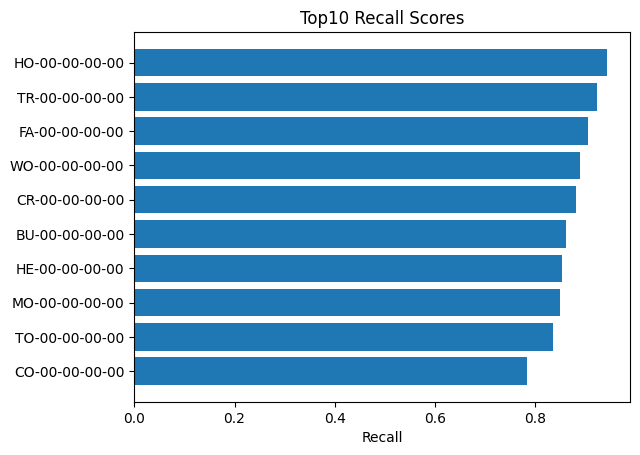

In [20]:


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1], reverse=True)
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])

ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Top10 Recall Scores')

plt.show()

## Bottom 10

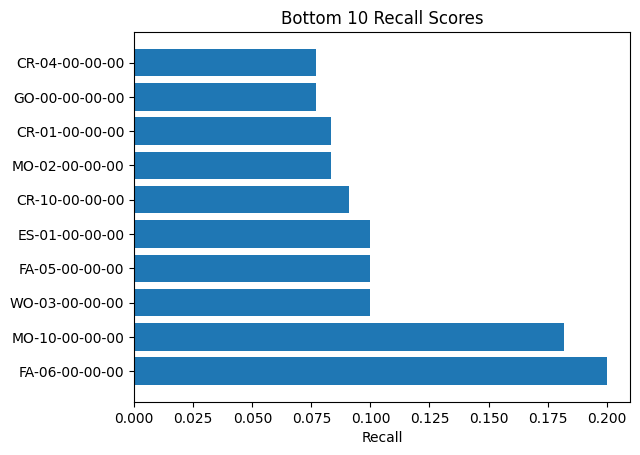

In [21]:


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]
    
sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1])
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])




ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Bottom 10 Recall Scores')

plt.show()

## Recall Distribution

    Recall
0    55.56
1    86.02
2    78.30
3    88.08
4     8.33
5     7.69
6    27.27
7     9.09
8    66.67
9    78.21
10   10.00
11   30.77
12   90.48
13   10.00
14   20.00
15   60.98
16    7.69
17   85.25
18   94.18
19   58.82
20   62.96
21   72.22
22   84.97
23    8.33
24   46.15
25   18.18
26   22.73
27   83.48
28   92.31
29   59.09
30   51.72
31   35.29
32   45.00
33   77.42
34   88.89
35   10.00


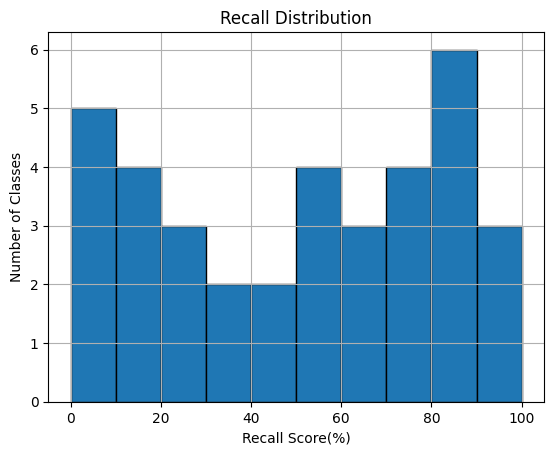

In [22]:
import pylab as pl

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

recall_list = []
for k,v in recall_dict.items():
    recall_list.append(v*100)
   
d = {'Recall': recall_list}
tinydf = pd.DataFrame(data=d)



hist = tinydf.hist(edgecolor='black', bins = [0,10,20,30,40,50,60,70,80,90,100])
pl.title("Recall Distribution")
pl.xlabel("Recall Score(%)")
pl.ylabel("Number of Classes")
print(tinydf)

## log_loss histogram

    logloss
0    0.0725
1    0.1005
2    0.1764
3    0.2397
4    0.0867
5    0.0881
6    0.0550
7    0.0658
8    0.0466
9    0.0747
10   0.0404
11   0.0603
12   0.1767
13   0.0514
14   0.0427
15   0.1291
16   0.0680
17   0.0828
18   0.1116
19   0.0905
20   0.0492
21   0.0376
22   0.2914
23   0.0458
24   0.0478
25   0.0502
26   0.1270
27   0.2901
28   0.1104
29   0.0728
30   0.0860
31   0.0666
32   0.0751
33   0.0382
34   0.1724
35   0.0662


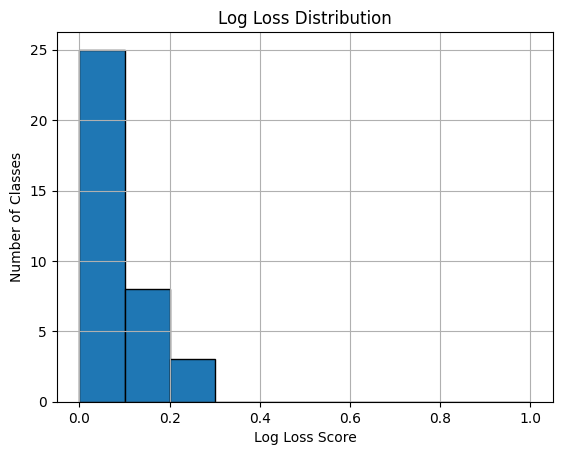

In [23]:
import pylab as pl

logloss_dict = defaultdict()
for k,v in stat_dict.items():
    logloss_dict[k] = v[5]

logloss_list = []
for k,v in logloss_dict.items():
    logloss_list.append(v)
   
d = {'logloss': logloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Log Loss Distribution")
pl.xlabel("Log Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

## Brier Score Loss

    brierloss
0      0.0178
1      0.0283
2      0.0483
3      0.0685
4      0.0170
5      0.0163
6      0.0104
7      0.0121
8      0.0119
9      0.0207
10     0.0094
11     0.0119
12     0.0508
13     0.0087
14     0.0077
15     0.0302
16     0.0149
17     0.0208
18     0.0291
19     0.0210
20     0.0094
21     0.0089
22     0.0877
23     0.0099
24     0.0128
25     0.0107
26     0.0265
27     0.0875
28     0.0282
29     0.0145
30     0.0196
31     0.0136
32     0.0154
33     0.0097
34     0.0478
35     0.0121


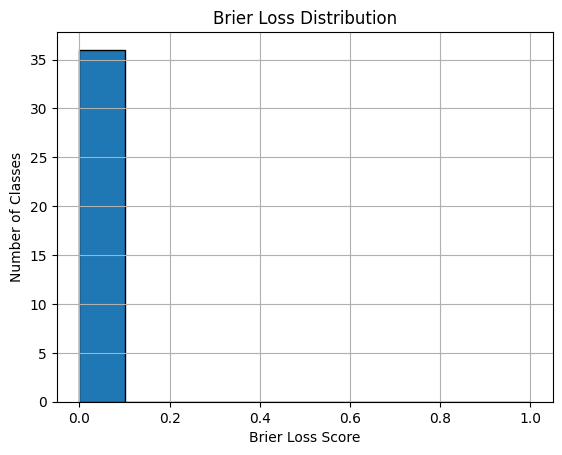

In [24]:

brierloss_dict = defaultdict()
for k,v in stat_dict.items():
    brierloss_dict[k] = v[6]

brierloss_list = []
for k,v in brierloss_dict.items():
    brierloss_list.append(v)
   
d = {'brierloss': brierloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Brier Loss Distribution")
pl.xlabel("Brier Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

# Custom Input Prediction

In [25]:
#text = "How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY state, not very helpful. Can i contact her insurance? Do I contact the police? Has this happened to anyone"
text = "I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take? Edit: I can’t find the title. My sister was coming back home from the army and I intended on giving her the car when she arrived. I most likely left the title in the car."
print(text)
input = sent2vec(text)
input = np.array(input)

predictions = defaultdict() 
prob = defaultdict()
c_logloss = defaultdict()

for cls in class_list:
    predictions[cls] = classifier[cls].predict([input])
    prob[cls] = classifier[cls].predict_proba([input])

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k][0][1], 4))


I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take? Edit: I can’t find the title. My sister was coming back home from the army and I intended on giving her the car when she arrived. I most likely left the title in the car.
CR-00-00-00-00 [1.] 0.8659
CR-01-00-00-00 [1.] 0.9078
MO-00-00-00-00 [1.] 0.6512
TO-00-00-00-00 [1.] 0.9321
TR-00-00-00-00 [1.] 0.9987
TR-01-00-00-00 [1.] 0.6617
TR-04-00-00-00 [1.] 0.9996
TR-05-00-00-00 [1.] 0.649
